# Credit Account Default Status and Characteristics

Data source: https://www.kaggle.com/datasets/mishra5001/credit-card?datasetId=263888&select=columns_description.csv

Credit history matters a lot when individuals want to take out loans ... say more about this later

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore")

In [5]:
original_df = pd.read_csv('data/application_data.csv')

In [6]:
original_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning

In [7]:
sorted_null = original_df.isnull().mean().sort_values(ascending=False)
sorted_null.index[(sorted_null>0.5)]

Index(['COMMONAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'OWN_CAR_AGE',
       'YEARS_BUILD_MEDI', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE',
       'LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'BASEMENTAREA_MEDI',
       'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1',
       'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG',
       'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'APARTMENTS_AVG',
       'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'WALLSMATERIAL_MODE'],
      dtype='object')

We observe that all the above columns contains more than X%(50% in our case) of nulls values, and here we make one of our major assumptions in this EDA that these data are simply unknown and can introduce bias which can affect our analysis(as opposed to them being actually informative and shows something in our data). Future work might involve taking a deeper look into these columns, but for now with this assumption in mind, we will drop these columns together with some additional columns like ID number, which we expect to be not useful in our analysis:

In [8]:
# drop columns with more then 50% missing values + additional ones decided by the group
drop_col = ['SK_ID_CURR',]
df = original_df[sorted_null.index[(sorted_null<0.5)]].drop(drop_col, axis=1)
#sorted_col_order = list(df.columns)
#sorted_col_order.sort()
#sorted_col_order
#df = df[sorted_col_order]
df.columns

Index(['LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI',
       'HOUSETYPE_MODE', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE',
       'OCCUPATION_TYPE', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'NAME_TYPE_SUITE',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'AMT_GOODS_PRICE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FL

## EDA

In the following parts of our analysis, we will identify some interesting findings in our data and attempt to build a logistic regression model to predict whether a customer will default or not. But for now, let us explore the different variables in our datasets.

First, we look at the general picture of what is the proportion of people using credit cards who are able to pay on time vs those who failed to pay on time.

### Target

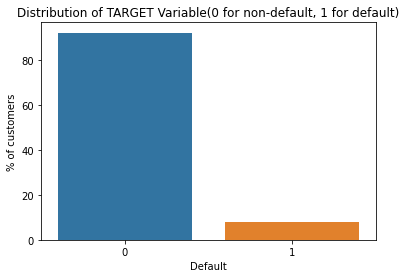

proportion of people who paid on time: 0.921583850931677
proportion of people who failed to pay on time: 0.07841614906832298


In [9]:
sns.barplot(x="TARGET", y="TARGET", data=df, estimator=lambda x: len(x) / len(df) * 100)
plt.xlabel("Default")
plt.ylabel("% of customers")
plt.title("Distribution of TARGET Variable(0 for non-default, 1 for default)")
plt.show()
print("proportion of people who paid on time:", 1-df["TARGET"].mean())
print("proportion of people who failed to pay on time:", df["TARGET"].mean())

Notice that there the original data has a high class imbalance, so we might want to bear this fact in mind when considering the metrics to look at when evaluating classifiers later. 

We will now examine the ratio of defaulters vs non-defaulters between some other categorical variables' groups 

In [10]:
def plot_default_in_category_group(group_name, df, x_label):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    title = 'Default Distribution Among Different ' + x_label +' Groups'
    ordering =  list(df[group_name].unique())
    
    sns.histplot(ax=ax1, x=group_name, data=df, stat='density', color='pink')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('percent')

    grouped = (df.groupby([group_name,'TARGET']).size() / df.groupby([group_name]).size()).reset_index().rename({0:'percent'}, axis=1)
    # renaming TARGET into default for clarity
    grouped = grouped[grouped['TARGET']==1].rename(columns = {'TARGET':"Default"})
    sns.barplot(ax = ax2, x=group_name, hue="Default", y='percent', data=grouped,order=ordering)
    ax2.set_xlabel(x_label)
    
    if (len(ordering) >= 5):
        ax1.set_xticklabels(ordering, rotation = 45)
        ax2.set_xticklabels(ordering, rotation = 45)
    f.suptitle(title)
    f.tight_layout()

def plot_default_in_numerical_discrete_group(group_name, df, x_label):
    filled = df[[group_name]].fillna(value=0)
    df[group_name] = filled
    # removing extreme outliers and calculating an appropriate binwidth
    sorted_df = list(df.sort_values(by=[group_name],ascending=False).index)[1000:]
    new_df = df.query('index in @sorted_df')
    new_df = new_df.rename(columns = {'TARGET':"Default"})
    
    
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    sns.histplot(data = new_df,x=group_name,binwidth=1, ax=ax1, color = 'pink', stat = 'density')
    
    ax1.set_xlabel(x_label)
    ax1.set_title('Distribution of '+x_label)
    
    prop = new_df[[group_name,'Default']].groupby(group_name).mean().reset_index()
    sns.lineplot(data = prop,x = group_name,y = 'Default', ax=ax2, color = 'blue')
    ax2.set_ylabel('Default Proportion')
    ax2.set_xlabel(x_label)
    ax2.set_title('Default Proportion vs '+ x_label)
    f.tight_layout()
    

### Loan Type

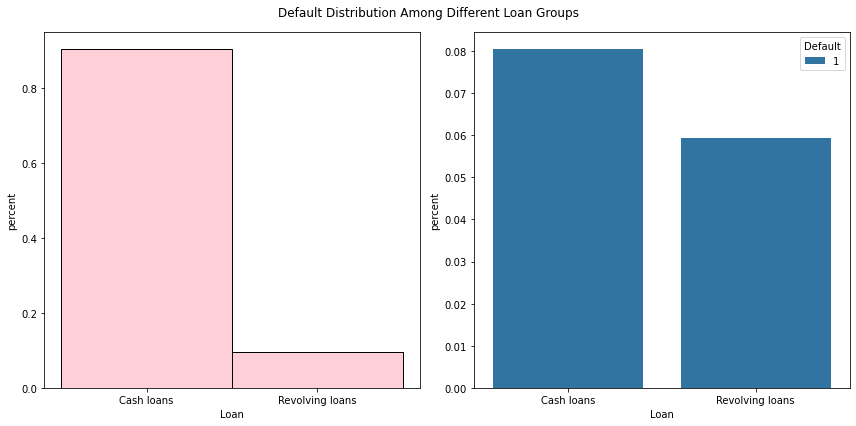

In [11]:
plot_default_in_category_group('NAME_CONTRACT_TYPE', df, 'Loan')

Observations: Cash loans seem to have a slightly higher proportion of defaults compared to revolving loans

### Gender

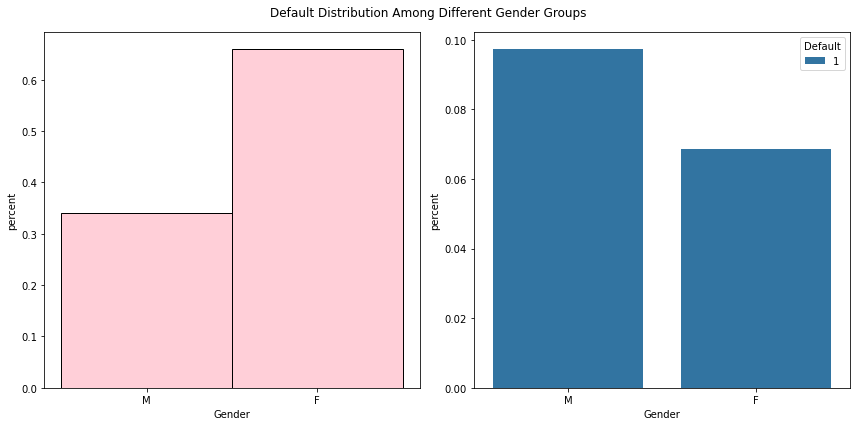

In [12]:
# omit the several XNA gender entries since we want to avoid assuming one's gender
gender_df = df[df['CODE_GENDER']!= 'XNA']
plot_default_in_category_group('CODE_GENDER', gender_df, 'Gender' )

Observations: Male seem to have a slightly higher proportion of defaults compared to female

### Income Type

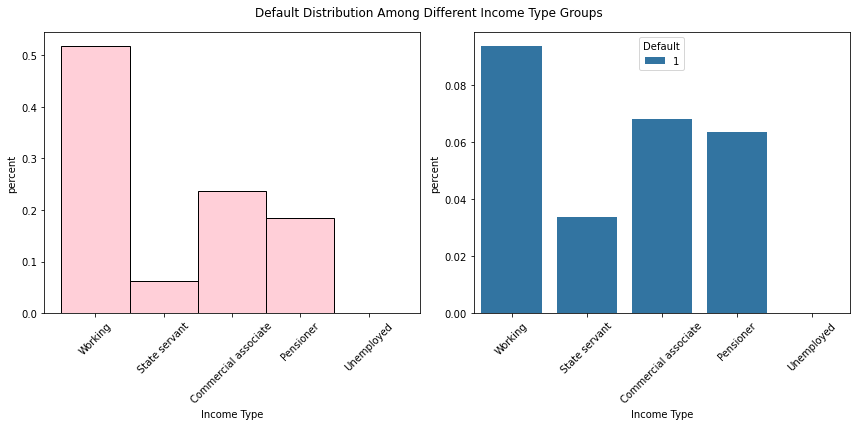

In [13]:
plot_default_in_category_group('NAME_INCOME_TYPE', df, 'Income Type')

Observations: Unemployed and Maternity leave groups seem to have a much higher proportion of default, whereas state servent and pensioner have a lower proportion of defaults among them.

### Education Type

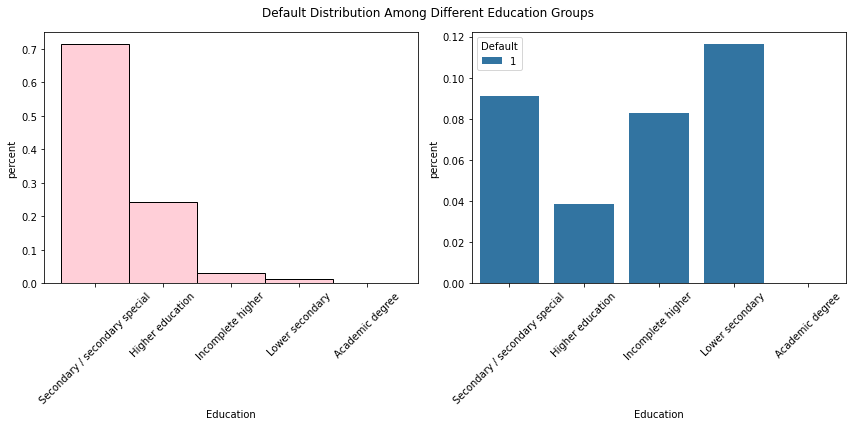

In [14]:
plot_default_in_category_group('NAME_EDUCATION_TYPE', df, 'Education')

Observations: Academic degree and higher education group have a lower proportion of defaults compared to the other groups that are slightly lower in educational degree status

### Family Status

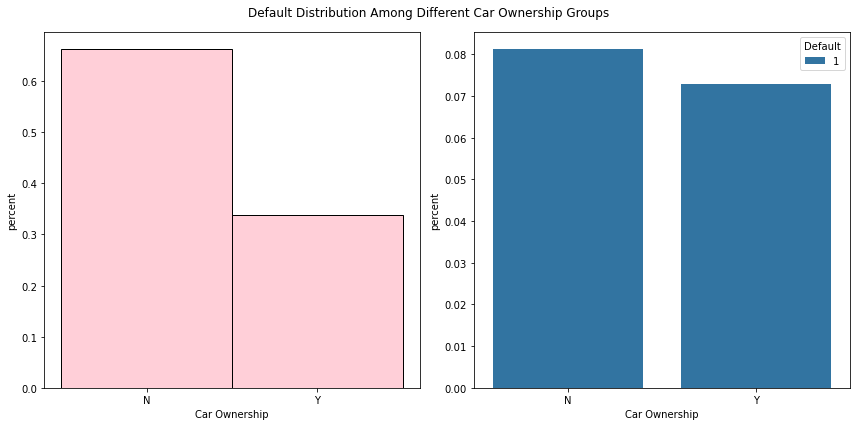

In [15]:
plot_default_in_category_group('FLAG_OWN_CAR', df, 'Car Ownership')

### House Ownership

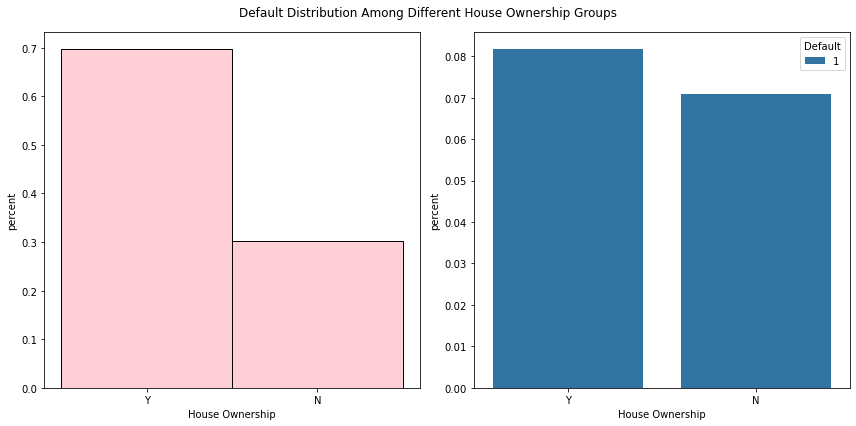

In [16]:
plot_default_in_category_group('FLAG_OWN_REALTY', df, 'House Ownership')

### House Type

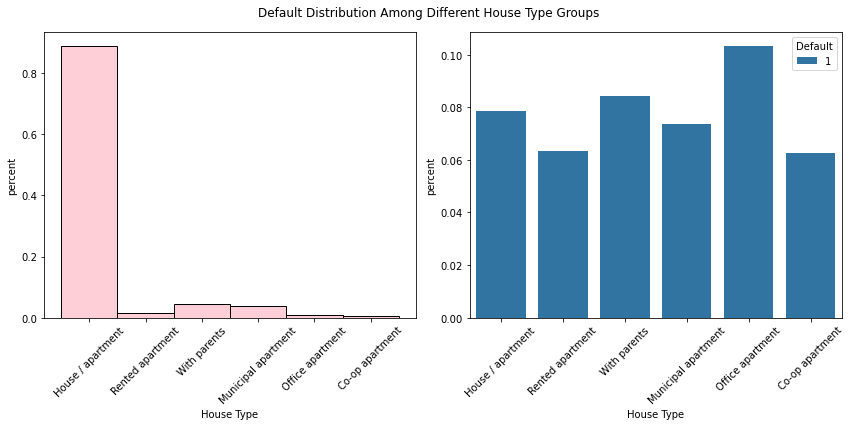

In [17]:
plot_default_in_category_group('NAME_HOUSING_TYPE', df, 'House Type')

### Number of Surrounding 30DPD Defaults

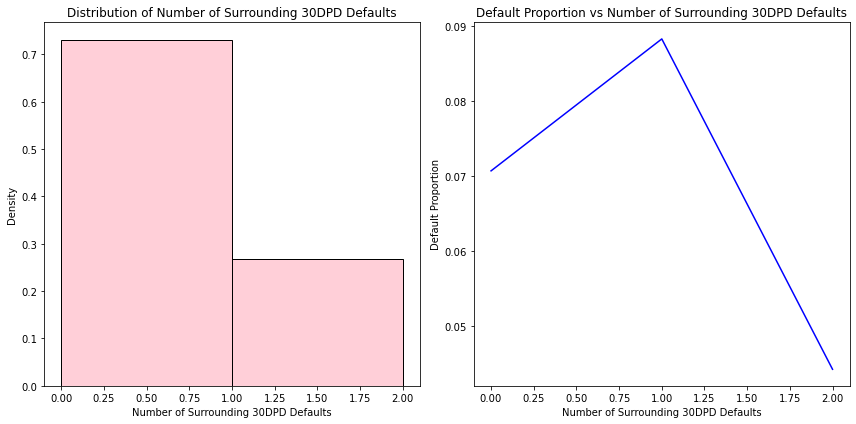

In [18]:
plot_default_in_numerical_discrete_group('OBS_30_CNT_SOCIAL_CIRCLE', df, 'Number of Surrounding 30DPD Defaults')

### Number of Family Members

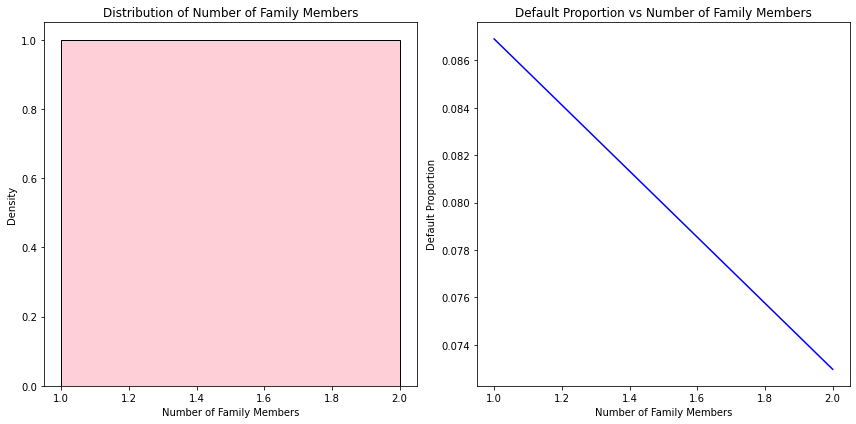

In [19]:
plot_default_in_numerical_discrete_group('CNT_FAM_MEMBERS', df, 'Number of Family Members')

In [20]:
########################

SelectedFeatures =['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
                   'FLAG_OWN_CAR','NAME_FAMILY_STATUS','OBS_30_CNT_SOCIAL_CIRCLE','CNT_FAM_MEMBERS',
                  'FLAG_OWN_REALTY']

## Logistic Regression Model

In [21]:
import sklearn.linear_model as lm

In [31]:
# preprocessing gender and flag_own_car 
categorical_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY','NAME_FAMILY_STATUS']
preprocessed = pd.get_dummies(df[SelectedFeatures], columns = categorical_cols)

In [33]:
model = lm.LogisticRegression(penalty = 'none', fit_intercept = True, solver = 'lbfgs')

In [34]:
model.fit(preprocessed, df['TARGET'])

LogisticRegression(penalty='none')

In [54]:
# displaying which coefficients are with which columsn

coefficients = pd.DataFrame({'feature': preprocessed.columns, 'coeff': model.coef_[0]}, columns=['feature', 'coeff'])
coefficients.sort_values(by='coeff').head()

,feature,coeff
11,NAME_EDUCATION_TYPE_Academic degree,-4.048285
4,CODE_GENDER_F,-0.743041
17,NAME_CONTRACT_TYPE_Revolving loans,-0.699606
3,FLAG_OWN_CAR_Y,-0.641262
18,FLAG_OWN_REALTY_N,-0.629254


In [38]:
# accuracy 

y_pred = model.predict(preprocessed)

np.mean(y_pred == df['TARGET'])

0.921583850931677

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['TARGET'], y_pred)
cm

array([[3561,    0],
       [ 303,    0]])

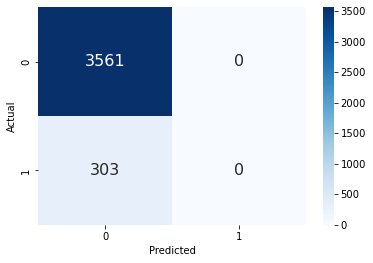

In [51]:
cm = confusion_matrix(df['TARGET'], y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

## *backup/extra code

In [56]:
# Finding the unique values for columns with categorical variables
unique_df = categorical_df.nunique().reset_index()
unique_df.columns = ['Column','Number of Unique Values']

# extract unique classes in each column
unique_df['Unique Values'] = unique_df['Column'].apply(lambda x: df[x].unique())
unique_df.sort_values(by='Number of Unique Values')

,Column,Number of Unique Values,Unique Values
0,EMERGENCYSTATE_MODE,2,"[No, nan, Yes]"
9,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
11,FLAG_OWN_CAR,2,"[N, Y]"
12,FLAG_OWN_REALTY,2,"[Y, N]"
10,CODE_GENDER,3,"[M, F, XNA]"
8,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
6,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
2,NAME_TYPE_SUITE,7,"[Unaccompanied, Family, Spouse, partner, Child..."
3,WEEKDAY_APPR_PROCESS_START,7,"[WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY..."


In [41]:
#correlation matrix 
#corr = numerical_df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# plt.savefig('output/correlation_matrix.png') # not sure how to save this figure

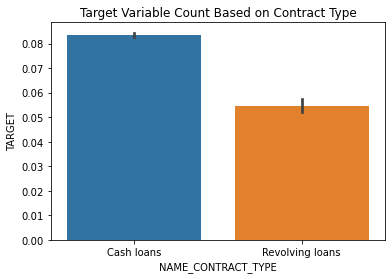

In [53]:
# how target variable varies depending on contract type - does this make sense? 

ax = sns.barplot(x="NAME_CONTRACT_TYPE", y="TARGET", data=df)
plt.title('Target Variable Count Based on Contract Type')
plt.savefig('output/target_contract_type_counts.png')

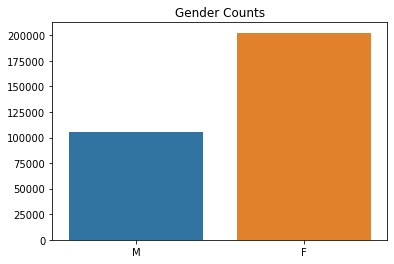

In [12]:
# Gender balance

ax = sns.barplot(x=['M', 'F'], y=[sum(df['CODE_GENDER']=='M'), sum(df['CODE_GENDER']=='F')])
plt.title('Gender Counts')
plt.savefig('output/gender_counts.png')

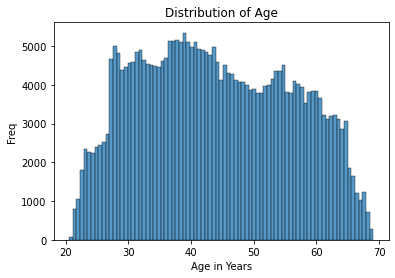

In [13]:
df['YEARS_BIRTH'] = -df['DAYS_BIRTH']/365.25

# plot the distribution of ages 

sns.histplot(data=df, x="YEARS_BIRTH")
plt.title('Distribution of Age')
plt.xlabel('Age in Years')
plt.ylabel('Freq')
plt.savefig('output/age_counts.png')

In [39]:
#for column in numerical_df.columns:
#    plt.figure(figsize=(20,5))
#    plt.subplot(121)
#    sns.distplot(df[column])
#    plt.title(column)
#    # save figure

In [40]:
#for column in categorical_df.columns:
#    plt.figure(figsize=(30,6))
#    plt.subplot(121)
#    sns.countplot(x=df[column],hue=df['TARGET'],data=df)
#    plt.title(column)    
#    plt.xticks(rotation=90)
#    # save figures

In [16]:
# Observations